# Project 3

Required libraries imported below

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

Data Generation

In [3]:
def is_dangerous(color_choices):
    if 3 in color_choices and 1 not in color_choices:
        return True
    return False

def one_hot_encode(color):
    arr = np.zeros(4)    
    arr[color-1] = 1
    return arr
    
def generate_wiring_diagram(part): #part signfies the part of the project the data is being generated for (1 or 2)
    if part != 1 and part != 2:
        print("invalid parameter values entered while calling generate_wiring_diagram(part) function, part can either be 1 or 2")
        return
    
    diagram = np.zeros((20,20,4), dtype=int) # Initializing a 20x20 blank diagram
    color_choices = [1, 2, 3, 4] # 1: Red, 2: Blue, 3: Yellow, 4: Green
    row_choices = list(range(0,20))
    col_choices= list(range(0,20))
    dangerous = False
    wire_to_cut = 0 # 0: No wire to cut, 1: Red, 2: Blue, 3: Yellow, 4: Green

    start_with_row = random.choice([True, False])
    
    if start_with_row: # True: Start with row, False: Start with column
        for i in range(4):
            if i%2 == 0:
                row = random.choice(row_choices) # Choosing a random row
                color = random.choice(color_choices) # Choosing a random color
                diagram[row, :] = one_hot_encode(color)
                row_choices.remove(row)
                color_choices.remove(color)
                if not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
            else:
                col = random.choice(col_choices) # Choosing a random column
                color = random.choice(color_choices) # Choosing a random color
                diagram[:, col] = one_hot_encode(color)
                col_choices.remove(col)
                color_choices.remove(color)
                if i == 1 and not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
                    
            if dangerous and i==2: # If the diagram is dangerous, the third wire placed is the one to cut
                wire_to_cut = color
                
    else:
        for i in range(4):
            if i%2 == 0:
                col = random.choice(col_choices) # Choosing a random column
                color = random.choice(color_choices) # Choosing a random color
                diagram[col, :] = one_hot_encode(color)
                col_choices.remove(col)
                color_choices.remove(color)
                if not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
            else:
                row = random.choice(row_choices) # Choosing a random row
                color = random.choice(color_choices) # Choosing a random color
                diagram[:, row] = one_hot_encode(color)
                row_choices.remove(row)
                color_choices.remove(color)
                if i == 1 and not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
                    
            if dangerous and i==2:
                wire_to_cut = color # If the diagram is dangerous, the third wire placed is the one to cut

    if part == 1: 
        return diagram, dangerous # If part is 1, return the diagram and whether it is dangerous or not
    elif part == 2:
        return diagram, wire_to_cut # If part is 2, return the diagram and the wire to cut

Memory Class to store dataset

In [4]:
# Creating a class to create our "dataset" for model training
class Memory:
    # Constructor
    def __init__(self, max_memory):
        self.max_memory = max_memory # maximum amount of samples to remember
        self.samples = [] # the samples

    # Adding a sample to memory
    def add_sample(self, diagram_vector, y):
        if [diagram_vector, y] not in self.samples: # Checking if the sample is already in memory
            self.samples.append((diagram_vector, y))
        if len(self.samples) > self.max_memory: # Removing the earliest sample if we reach maximum memory
            self.samples.pop(0)
        return len(self.samples)
    

    # Sampling the samples we have in memory
    def sample(self, no_samples): #no_samples is the number of samples you need
        if no_samples > len(self.samples):
            return random.sample(self.samples, len(self.samples))
        else:
            return random.sample(self.samples, no_samples)

In [4]:
def findConstants(diagram):
    curr = diagram
    colors = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
    constants = np.zeros(4) #An array that will contain the constant that represents relatively how much each wire is from its original color 
    for x in range(len(colors)): #For each color wire, we want to find the distance from edges
        found_in_row = False
        found_in_col = False
        for i in range(len(curr)): #Finds if the color wire is present as a row
            element_count = np.count_nonzero(np.all(curr[i] == colors[x], axis=1))#Finds the number of occurences of that color in that row
            if(element_count/len(curr[i]) >= 0.5):
                found_in_row = True
                constants[x] = element_count/len(curr[i]) * 100.0
                break
        if(not found_in_row):
            for i in range(len(curr[0])): # Finds if the color wire is present as a col
                element_count = np.count_nonzero(np.all(curr[:, i] == colors[x], axis=1)) # Finds the number of occurences of that color in that column
                if(element_count/len(curr) >= 0.5):
                    found_in_col = True
                    constants[x] = element_count/len(curr) * 100.0
                    break
    return np.tanh(constants/100)


Data generation for part 1

In [15]:
diagrams = 10000 #number of max diagrams to be stored in Memory class
memory = Memory(diagrams) #more than diagrams and the oldest diagram stored will be removed
diagram_arr = []
training_size = 5000
testing_size = 5000
for i in range(diagrams):
    diagram, y = generate_wiring_diagram(1) #type:ignore
    memory.add_sample(diagram, int(y))
samples = memory.sample(training_size+testing_size)
training_data = samples[:training_size]
testing_data = samples[training_size:]
x_train = []
y_train = []
x_test = []
y_test = []
for diagram in training_data:
    additional_features = findConstants(diagram[0])
    x_train.append(np.concatenate(([1], diagram[0].flatten(), additional_features))) #A vector with each component being a vector of the each sample diagram's features
    y_train.append(diagram[1])
for diagram in testing_data:
    additional_features = findConstants(diagram[0])
    x_test.append(np.concatenate(([1], diagram[0].flatten(), additional_features))) #A vector with each component being a vector of the each sample diagram's features
    y_test.append(diagram[1])


[0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 1 0 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0][0 0 1 0]
[0 0 0 1][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 1 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0]
[0 0 0 1][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][0 1 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0][1 0 0 0]
[0 0 0 1][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 1 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0]
[0 0 0 1][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 1 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0]
[0 0 0 1][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 0 0][0 0 

data gen leroy's implementation

In [6]:
diagrams = 6000 #number of max diagrams to be stored in Memory class
train_size = 5000 #number of samples to be generated
test_size = 1000 #number of samples to be used for testing
memory = Memory(diagrams) #more than diagrams and the oldest diagram stored will be removed

#generating 5000 diagrams and storing them in memory
len_samples = 0
while len_samples!=diagrams:
    diagram, y = generate_wiring_diagram(1) #type:ignore
    len_samples = memory.add_sample(diagram, y)
samples = memory.sample(train_size+test_size)

train_samples = samples[:train_size]
test_samples = samples[train_size:]

diagram_arr = []
y_arr = []
for diagrams, y in train_samples:
    diagram_arr.append(diagrams)
    y_arr.append(y)
    
test_diagram_arr = []
test_y_arr = []    
for test_diagrams, test_y in test_samples:
    test_diagram_arr.append(test_diagrams)
    test_y_arr.append(test_y)

y_arr = np.array(y_arr) #converting the y_arr to a numpy array for easier computation
test_y_arr = np.array(test_y_arr) #converting the test_y_arr to a numpy array for easier computation

In [7]:
def process_data_part1(diagram_arr, y_arr):
    flattened_diagrams = np.array([diagram.flatten() for diagram in diagram_arr])
    additional_features = np.array([diagram.sum(axis=(0, 1)) for diagram in diagram_arr])
    additional_features = np.square(np.subtract(additional_features[:, [0,2]], 17))
    X_combined = np.concatenate((flattened_diagrams, additional_features), axis=1)
    X = np.c_[X_combined, np.ones(X_combined.shape[0])]
    Y = y_arr.astype(int)
    
    return X, Y

In [210]:
X_train, Y_train = process_data_part1(diagram_arr, y_arr)
X_test, Y_test = process_data_part1(test_diagram_arr, test_y_arr)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"First element of X_train: {X_train[0]}")
print(f"First 5 elements of Y_train: {Y_train[:100]}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"First element of X_test: {X_test[0]}")

X_train shape: (1000, 1603)
Y_train shape: (1000,)
First element of X_train: [0. 0. 0. ... 9. 1. 1.]
First 5 elements of Y_train: [0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0
 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0
 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0]
X_test shape: (1000, 1603)
Y_test shape: (1000,)
First element of X_test: [0. 0. 0. ... 4. 1. 1.]


In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegression():
    
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.regularization = 0.001
        self.test_loss_history = []
        self.train_loss_history = []
        self.epsilon = 1e-10
    
    def fit(self, X_train, Y_train, X_test, Y_test, learning_rate=0.001, epochs=10):
        m = X_train.shape[0]
        for epoch in range (epochs):
            z = np.dot(X_train, self.W) + self.b
            A = sigmoid(z)
            
            loss = -np.mean(y * np.log(A + self.epsilon) + (1 - y) * np.log(1 - A + self.epsilon))
            loss += self.regularization * np.sum(np.square(self.W)) / (2 * m)
            self.train_loss_history.append(loss)
            
            z_test = np.dot(X_test, self.W) + self.b
            A_test = sigmoid(z_test)
            
            loss_test = -np.mean(Y_test * np.log(A_test + self.epsilon) + (1 - Y_test) * np.log(1 - A_test + self.epsilon))
            loss_test += self.regularization * np.sum(np.square(self.W)) / (2 * m)
            self.test_loss_history.append(loss_test)
            
            dz = A - Y_train
            dW = np.dot(X_train.T, dz) / m + self.regularization * self.W / m
            db = np.sum(dz) / m + self.regularization * self.b / m
            
            self.W -= learning_rate * dW
            self.b -= learning_rate * db
            
            print("Epoch: ", epoch, "Loss: ", loss, "Test Loss: ", loss_test)
        
        self.plot_loss(self.train_loss_history, self.test_loss_history)
    
    def predict(self, X):
        z = np.dot(X, self.W) + self.b
        A = sigmoid(z)
        return np.round(A)
    
    def plot_loss(self, train_loss, test_loss):
        plt.plot(train_loss, label="Train Loss")
        plt.plot(test_loss, label="Test Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.legend()
        plt.show()

In [7]:
num_features = X_train.shape[1]
W = np.random.randn(num_features)
b = 0
model = LogisticRegression(W, b)

NameError: name 'X_train' is not defined

Epoch:  0 Loss:  4.267999860386127 Test Loss:  3.114224766611004
Epoch:  1 Loss:  4.2543811442218455 Test Loss:  3.0968511434540886
Epoch:  2 Loss:  4.2412251771136 Test Loss:  3.0796704186295996
Epoch:  3 Loss:  4.22851969003135 Test Loss:  3.062678583809413
Epoch:  4 Loss:  4.216252822242935 Test Loss:  3.045871763823656
Epoch:  5 Loss:  4.204413112621184 Test Loss:  3.029246226122084
Epoch:  6 Loss:  4.192989489510891 Test Loss:  3.012798379058715
Epoch:  7 Loss:  4.181971259091072 Test Loss:  2.996524758029705
Epoch:  8 Loss:  4.171348092183387 Test Loss:  2.9804220378595634
Epoch:  9 Loss:  4.1611100095111695 Test Loss:  2.964487014658665
Epoch:  10 Loss:  4.151247365491785 Test Loss:  2.948716611017302
Epoch:  11 Loss:  4.141750830734157 Test Loss:  2.933107871268247
Epoch:  12 Loss:  4.132611373500461 Test Loss:  2.917657946782922
Epoch:  13 Loss:  4.123820240465686 Test Loss:  2.9023641011392978
Epoch:  14 Loss:  4.11536893716305 Test Loss:  2.887223697763364
Epoch:  15 Loss:  

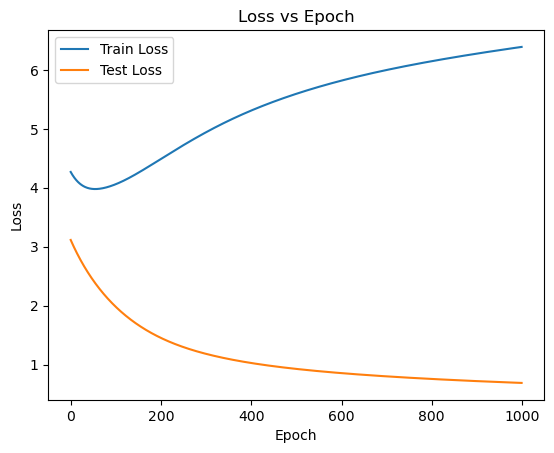

In [214]:
#training the model
model.fit(X_train, Y_train, X_test, Y_test, learning_rate=0.01, epochs = 1000)

In [207]:
predictions = model.predict(X_test)

correct_predictions = np.sum(predictions == test_y_arr)
print(correct_predictions)
accuracy = (correct_predictions / Y_test.shape[0])*100
print(f"Accuracy on test set: {accuracy}")


504
Accuracy on test set: 50.4


Model for Part 1

In [64]:
class LogisticRegressionModel():
    def __init__(self, weights, alpha, epochs, lambdaVar):
        self.weights = weights
        self.alpha = alpha
        self.epochs = epochs
        self.train_loss_history = []
        self.test_loss_history = []
        self.lambdaVar = lambdaVar

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def log(self, x):
        return np.log10(x)

    def costFunction (self, features, y): #Loss Function
        loss = -1 * y * self.log(self.sigmoid(np.dot(self.weights, features)) - (1-y) * self.log(self.sigmoid(1-np.dot(self.weights, features))))
        return loss

    def gradientDescent(self, features, weights, alpha, y):
        regularization = 0
        for x in range(1, len(self.weights)):
            regularization += (self.weights[x])**2
        regularization = self.lambdaVar/(2 * len(self.weights)) * regularization
        gradient = np.zeros(len(weights))
        func = self.sigmoid(np.dot(features, self.weights))
        gradient = np.dot((func - y), features) + regularization * np.concatenate(([0], np.ones(len(self.weights)-1)))
        self.weights = self.weights - alpha * gradient
        print(self.weights)

    def fit(self, weights, alpha, x_train, y_train, x_test, y_test, epochs):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        for epoch in range(epochs): #Epochs
            regularization = 0
            for x in range(1, len(self.weights)):
                regularization += (self.weights[x])**2
            regularization *= self.lambdaVar / (2 * len(self.weights))
            print("Regularization: ", regularization)
            for j in range(len(x_train)): #Loop through each sample in the dataset
                self.gradientDescent(self.x_train[j], self.weights, self.alpha, self.y_train[j]) 
            loss_train = 0
            for x in range(len(x_train)): #Calculate the loss for the training data
                loss_train+=self.costFunction(self.x_train[x], self.y_train[x])
            loss_train /= len(self.x_train)
            print("asd", loss_train)
            loss_train+=regularization
            print("gd", loss_train)
            self.train_loss_history.append(loss_train)
            loss_test = 0 
            for x in range(len(x_test)): #Calculate the loss for the testing data
                loss_test+=self.costFunction(self.x_test[x], self.y_test[x])
            loss_test /= len(self.x_test)
            loss_test+=regularization
            self.test_loss_history.append(loss_test)
            
            print("Epoch: ", epoch, "Loss: ", loss_train)
        self.plot_loss(self.train_loss_history, self.test_loss_history)
    
    def predict(self, X): #Check if this method works correctly!!!!!!!!!!!!!!!!!!!!!!!!!!
        A = np.empty(len(X))
        for i in range(len(X)):
            z = np.dot(X[i], self.weights)
            A[i] = sigmoid(z)
        return np.round(A)


    def plot_loss(self, train_loss, test_loss): #Plot the Epochs vs both Training and Testing Loss Curves
        plt.plot(train_loss, label="Train Loss")
        plt.plot(test_loss, label="Test Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.legend()
        plt.show()   
        
    #saving and loading the model
    def save_model(self, name):
        np.savez(name, weights = self.weights)
         

weights = np.random.randn(len(x_train[0])) #Randomize weights
alpha = 0.05 # Left at 0.05 for now
epochs = 100 #Number of epochs
lambdaVariable = 0.05
model = LogisticRegressionModel(weights, alpha, epochs, lambdaVariable)
model.fit(weights, alpha, x_train, y_train, x_test, y_test, epochs)

Regularization:  77.23754351550474
[ 1.44165486 -1.03243041 -1.12814495 ... -0.56291766 -0.44419557
 -0.76810602]
[ 1.4431637  -1.03363311 -1.12934765 ... -0.56297123 -0.44428206
 -0.76822794]
[ 1.49316154 -1.03483585 -1.13055039 ... -0.52609591 -0.40849724
 -0.73361733]
[ 1.51174582 -1.0174536  -1.13175242 ... -0.51398606 -0.39554559
 -0.72107102]
[ 1.46267777 -1.01865566 -1.13295448 ... -0.55255806 -0.431895
 -0.7585728 ]
[ 1.46303051 -1.01985773 -1.13415655 ... -0.55349148 -0.43283611
 -0.7595222 ]
[ 1.41307984 -1.02105985 -1.13535867 ... -0.59273574 -0.46981779
 -0.79767698]
[ 1.41306769 -1.02226176 -1.13656058 ... -0.59394664 -0.47102869
 -0.79888759]
[ 1.36306769 -1.02346373 -1.13776256 ... -0.63213777 -0.50804556
 -0.83816928]
[ 1.31319399 -1.02466396 -1.13896278 ... -0.67023372 -0.54497022
 -0.87626522]
[ 1.26322254 -1.02586406 -1.14016289 ... -0.70840185 -0.58196476
 -0.91443336]
[ 1.26322154 -1.02706394 -1.14136277 ... -0.70960249 -0.58316536
 -0.91563398]
[ 1.26305159 -1.028

C:\Users\nsu_s\AppData\Local\Temp\ipykernel_15884\3786432158.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\nsu_s\AppData\Local\Temp\ipykernel_15884\3786432158.py:23: RuntimeWarning: overflow encountered in scalar power
  regularization += (self.weights[x])**2
C:\Users\nsu_s\AppData\Local\Temp\ipykernel_15884\3786432158.py:27: RuntimeWarning: invalid value encountered in multiply
  gradient = np.dot((func - y), features) + regularization * np.concatenate(([0], np.ones(len(self.weights)-1)))


[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[nan nan n

In [44]:
predictions = model.predict(x_test) 

correct_predictions = np.sum(predictions == y_test)
print(correct_predictions)
accuracy = (correct_predictions / np.array(y_test).shape[0])*100
print(f"Accuracy on test set: {accuracy}")


4395
Accuracy on test set: 87.9


In [ ]:
model.save_model("model_non_linear.npz")

Data generation for part 2

In [8]:
diagrams = 6000 #number of max diagrams to be stored in Memory class
train_size = 5000 #number of samples to be generated
test_size = 1000 #number of samples to be used for testing
memory = Memory(diagrams) #more than diagrams and the oldest diagram stored will be removed

#generating 5000 diagrams and storing them in memory
len_samples = 0
while len_samples!=diagrams:
    diagram, y = generate_wiring_diagram(2) #type:ignore
    if y!=0:
        len_samples = memory.add_sample(diagram, y)
samples = memory.sample(train_size+test_size)


train_samples = samples[:train_size]
test_samples = samples[train_size:]

diagram_arr = []
y_arr = []
for diagrams, y in train_samples:
    diagram_arr.append(diagrams)
    y_arr.append(y)
    
test_diagram_arr = []
test_y_arr = []    
for test_diagrams, test_y in test_samples:
    test_diagram_arr.append(test_diagrams)
    test_y_arr.append(test_y)

y_arr = np.array(y_arr) #converting the y_arr to a numpy array for easier computation
test_y_arr = np.array(test_y_arr) #converting the test_y_arr to a numpy array for easier computation

Data Processing

In [9]:
def process_data_part2(diagram_arr, y_arr):
    
    flattened_diagrams = np.array([diagram.flatten() for diagram in diagram_arr])
    
    #generate additional features
    sum_of_pixels = np.array([diagram.sum(axis=(0, 1)) for diagram in diagram_arr])
    additional_features = np.abs(np.subtract(sum_of_pixels, 19))
    additional_features = np.square(np.add(additional_features,2))
    
    #some more additional features
    positions = np.where(sum_of_pixels == 19)[1].reshape(-1,2) #finding what color of wire contains 19 pixels
    e_vector = np.eye(4)[positions]
    new_vector = []
    row = 0
    col = 0
    for i in range(len(diagram_arr)):
        for j in range(2):
            indices = np.where(np.all(diagram_arr[i] == e_vector[i][j], axis = 2))
            if indices[0][0] == indices[0][1]:
                row = indices[0][0]
            elif indices[1][0] == indices[1][1]:
                col = indices[1][0]
        for j in range(2):
            if tuple(e_vector[i][j]) == tuple(diagram_arr[i][row][col]):
                new_vector.append(1)
            else:
                new_vector.append(0)
                
    new_vector = np.array(new_vector).reshape(-1,2)
    new_vector = np.square(np.exp(new_vector))
    
    X_combined = np.concatenate((flattened_diagrams, additional_features, new_vector), axis=1)
    X = np.c_[X_combined, np.ones(X_combined.shape[0])]
    Y = np.eye(4)[np.subtract(y_arr,1)]
    
    return X, Y

In [10]:
def process_data_bad(diagram_arr, y_arr):
    
    flattened_diagrams = np.array([diagram.flatten() for diagram in diagram_arr])
    
    #generate additional features
    sum_of_pixels = np.array([diagram.sum(axis=(0, 1)) for diagram in diagram_arr])
    additional_features = np.abs(np.subtract(sum_of_pixels, 19))
    additional_features = np.square(np.add(additional_features,2))     
    
    X_combined = np.concatenate((flattened_diagrams, additional_features), axis=1)
    X = np.c_[X_combined, np.ones(X_combined.shape[0])]
    Y = np.eye(4)[np.subtract(y_arr,1)]
    
    return X, Y

In [11]:
X_train, Y_train = process_data_part2(diagram_arr, y_arr)
X_test, Y_test = process_data_part2(test_diagram_arr, test_y_arr)
X_train_bad, Y_train_bad = process_data_bad(diagram_arr, y_arr)
X_test_bad, Y_test_bad = process_data_bad(test_diagram_arr, test_y_arr)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"First 5 element of X_train: {X_train[:5]}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"First 5 element of X_test: {X_test[:5]}")

X_train shape: (5000, 1607)
Y_train shape: (5000, 4)
First 5 element of X_train: [[0.        0.        0.        ... 7.3890561 1.        1.       ]
 [0.        0.        0.        ... 1.        7.3890561 1.       ]
 [0.        0.        0.        ... 7.3890561 1.        1.       ]
 [0.        0.        0.        ... 7.3890561 1.        1.       ]
 [1.        0.        0.        ... 1.        7.3890561 1.       ]]
X_test shape: (1000, 1607)
Y_test shape: (1000, 4)
First 5 element of X_test: [[0.        0.        0.        ... 7.3890561 1.        1.       ]
 [1.        0.        0.        ... 1.        7.3890561 1.       ]
 [0.        0.        0.        ... 7.3890561 1.        1.       ]
 [0.        0.        0.        ... 1.        7.3890561 1.       ]
 [0.        0.        0.        ... 7.3890561 1.        1.       ]]


Part 2 implementation

In [13]:
#defining the softmax function
def softmax(x): 
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

class Model():
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.epsilon = 1e-10
        self.regularization = 0.01
        self.train_loss_history = []
        self.test_loss_history = []
        
    def fit(self, X_train, Y_train, X_test, Y_test, learning_rate = 0.001, epochs = 10):
        m = X_train.shape[0]
        for epoch in range(epochs):
            
            #forward propagation for training
            Z_train = np.dot(X_train, self.W) + self.b
            A_train = softmax(Z_train)
            
            loss_train = -np.mean(np.sum(Y_train * np.log(A_train + self.epsilon), axis=1)) #calculating the loss
            loss_train += 0.5 * self.regularization * np.sum(self.W ** 2) #calculating the regularization loss
            
            self.train_loss_history.append(loss_train)
            
            # Forward pass for test data
            Z_test = np.dot(X_test, self.W) + self.b
            A_test = softmax(Z_test)
            
            loss_test = -np.mean(np.sum(Y_test * np.log(A_test + self.epsilon), axis=1))
            loss_test += 0.5 * self.regularization * np.sum(self.W ** 2)
            self.test_loss_history.append(loss_test)
            
            #calculating the gradients
            dW = (1/m) * np.dot(X_train.T, (A_train-Y_train)) + (self.regularization * self.W)
            db = (1/m) * np.sum(A_train-Y_train, axis=0) + (self.regularization * self.b)
            
            #updating the weights and biases
            self.W -= learning_rate * dW 
            self.b -= learning_rate * db
            
            print("Epoch: ", epoch, "Loss: ", loss_train)
        
        self.plot_loss(self.train_loss_history, self.test_loss_history)

    def predict(self, X): #prediction function
        Z = np.dot(X, self.W) + self.b
        probs = softmax(Z)
        return np.argmax(probs, axis=1) + 1
    
    #plotting the loss
    def plot_loss(self, train_loss_history, test_loss_history):
        plt.plot(train_loss_history, label = "train loss")
        plt.plot(test_loss_history, label = "train loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.legend()
        plt.show()
    
    #saving and loading the model
    def save_model(self, name):
        np.savez(name, W=self.W, b=self.b)
        
    def load_model(self, name):
        loaded_data = np.load(name)
        self.W = loaded_data['W']
        self.b = loaded_data['b']

In [26]:
num_classes = 4
num_features = X_train.shape[1]
W = np.random.rand(num_features, num_classes)
b = np.zeros(num_classes)
model = Model(W, b)

In [27]:
num_features = X_train_bad.shape[1]
W = np.random.rand(num_features, num_classes)
b = np.zeros(num_classes)
model_bad = Model(W, b)

In [98]:
model.load_model('model_non_linear.npz')  # Load weights from a saved file

Epoch:  0 Loss:  17.862657104640537
Epoch:  1 Loss:  15.920590082073698
Epoch:  2 Loss:  14.491790511334973
Epoch:  3 Loss:  13.750385239883796
Epoch:  4 Loss:  13.54373656156772
Epoch:  5 Loss:  13.09806276373052
Epoch:  6 Loss:  12.989389542509542
Epoch:  7 Loss:  12.658018392265056
Epoch:  8 Loss:  12.562969103002368
Epoch:  9 Loss:  12.301080887649015
Epoch:  10 Loss:  12.20079975561901
Epoch:  11 Loss:  12.003747704634499
Epoch:  12 Loss:  11.90046436059733
Epoch:  13 Loss:  11.757154584586129
Epoch:  14 Loss:  11.66167960889262
Epoch:  15 Loss:  11.558668244169896
Epoch:  16 Loss:  11.478210953970006
Epoch:  17 Loss:  11.40210194445859
Epoch:  18 Loss:  11.336654809167102
Epoch:  19 Loss:  11.276846555795249
Epoch:  20 Loss:  11.222576238095511
Epoch:  21 Loss:  11.172375894829404
Epoch:  22 Loss:  11.125447049302183
Epoch:  23 Loss:  11.081179623708465
Epoch:  24 Loss:  11.039081086425218
Epoch:  25 Loss:  10.998824913493783
Epoch:  26 Loss:  10.960152694027194
Epoch:  27 Loss: 

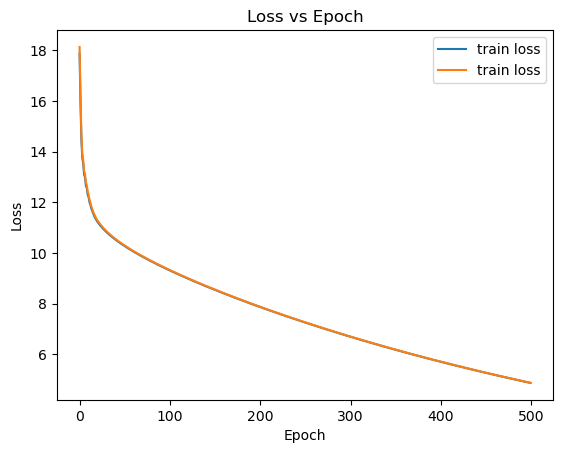

In [28]:
#training the model
model.fit(X_train, Y_train, X_test, Y_test, learning_rate=0.08, epochs = 500)

Epoch:  0 Loss:  15.604140085474448
Epoch:  1 Loss:  14.19891214244388
Epoch:  2 Loss:  13.566562532055498
Epoch:  3 Loss:  13.314557839725447
Epoch:  4 Loss:  13.121916193616975
Epoch:  5 Loss:  12.960392941548713
Epoch:  6 Loss:  12.81937518745026
Epoch:  7 Loss:  12.6977976294432
Epoch:  8 Loss:  12.589756132555895
Epoch:  9 Loss:  12.494838904201877
Epoch:  10 Loss:  12.409960832693073
Epoch:  11 Loss:  12.334163417627616
Epoch:  12 Loss:  12.265702865609796
Epoch:  13 Loss:  12.203499463243439
Epoch:  14 Loss:  12.146458205972968
Epoch:  15 Loss:  12.093740619385922
Epoch:  16 Loss:  12.044648088918533
Epoch:  17 Loss:  11.99862362446673
Epoch:  18 Loss:  11.955218262482507
Epoch:  19 Loss:  11.914066152157927
Epoch:  20 Loss:  11.8748667731258
Epoch:  21 Loss:  11.8373698341539
Epoch:  22 Loss:  11.801365529887844
Epoch:  23 Loss:  11.766676499448238
Epoch:  24 Loss:  11.73315210561101
Epoch:  25 Loss:  11.700663700264556
Epoch:  26 Loss:  11.669100961540666
Epoch:  27 Loss:  11.

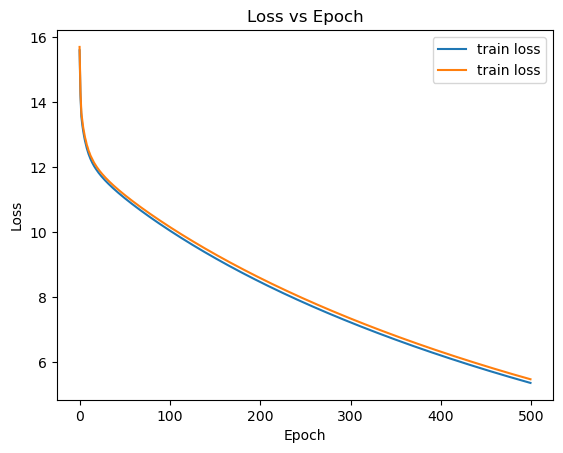

In [29]:
model_bad.fit(X_train_bad, Y_train_bad, X_test_bad, Y_test_bad, learning_rate=0.08, epochs = 500)

In [24]:
predictions = model.predict(X_test)

correct_predictions = np.sum(predictions == test_y_arr)
print(correct_predictions)
accuracy = (correct_predictions / Y_test.shape[0])*100
print(f"Accuracy on test set: {accuracy}")



1000
Accuracy on test set: 100.0


In [31]:
predictions = model_bad.predict(X_test_bad)

correct_predictions = np.sum(predictions == test_y_arr)
print(correct_predictions)
accuracy = (correct_predictions / Y_test.shape[0])*100
print(f"Accuracy on test set: {accuracy}")


582
Accuracy on test set: 58.199999999999996


In [18]:
predictions = model.predict(X_train)

correct_predictions = np.sum(predictions == y_arr)
print(correct_predictions)
accuracy = (correct_predictions / Y_train.shape[0])*100
print(f"Accuracy on training set: {accuracy}")


4446
Accuracy on training set: 88.92


In [302]:
model.save_model("model_non_linear.npz")